In [1]:
import sys
import os
workPath = os.path.abspath('..')
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
from timeit import timeit
import numpy as np
from scipy import stats
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import linear_model
import numpy as np
def regress(dataFrame, xs, y, keytuple = None, rounding = 2, intercept = True):
    lmOut = []
    lm = linear_model.LinearRegression(fit_intercept = True)
    if type(xs) == str:
        xs = [xs,]
    if not keytuple is None:
        key, keyval = keytuple
        dataFrame = dataFrame.loc[dataFrame[key] == keyval]
    dataXs = list(zip(*[dataFrame[x] for x in xs]))
    dataY = dataFrame[y]
    lm.fit(dataXs, dataY)
    lmOut = [np.round(item, rounding) for item in (lm.coef_, lm.intercept_, lm.score(dataXs, dataY))]
    lmOut[0] = list(lmOut[0])
    header = y + " vs " + str(xs) + '; coef, intercept, score:'
    return header, lmOut
def regress_series(dataFrame, xs, y, key, rounding = 2, intercept = True):
    outList = []
    header = ''
    for keyval in sorted(set(dataFrame[key])):
        header, datarow = regress(
            dataFrame,
            xs,
            y,
            keytuple = (key, keyval),
            rounding = rounding,
            intercept = intercept
            )
        outList.append((round(keyval, rounding), datarow))
    header = key + "; " + header
    return header, outList

In [4]:
from everest import window
from everest import _specialnames
Fetch = window.Fetch
Reader = window.Reader

In [5]:
projName = 'arrbench64'
outputPath = os.path.join(*['..', 'out', 'analysis', projName])
filePath = os.path.join(outputPath, projName + '.h5')

In [6]:
myreader = Reader(filePath)

In [7]:
filterScope = myreader[Fetch('Nu') > 0.]
attrDict = myreader.view_attrs(filterScope)

In [8]:
np.round(np.log10(sorted((attrDict['Ra'].keys()))), 1)

array([3., 4., 5., 6., 7.])

In [9]:
np.round(np.log10(sorted((attrDict['eta0'].keys()))), 1)

array([0., 1., 2., 3., 4.])

In [10]:
sorted((attrDict['f'].keys()))

[0.2, 0.4, 0.6, 0.8, 1.0]

In [11]:
fs = sorted(attrDict['f'].keys())
Ras = sorted(attrDict['Ra'].keys())
eta0s = sorted(attrDict['eta0'].keys())

allData = []

for f in fs:
    fScope = attrDict['f'][f]
    for Ra in Ras:
        RaScope = attrDict['Ra'][Ra]
        for eta0 in eta0s:
            etaScope = attrDict['eta0'][eta0]
            thisScope = fScope * RaScope * etaScope
            if len(thisScope):
                Nus, modeltimes = myreader.pull(thisScope, ('Nu', 'modeltime'))
                recentNus, recentModeltimes = Nus[-100:], modeltimes[-100:]
                intervals = np.diff(recentModeltimes)
                NuAv = np.average(recentNus[1:], weights = intervals)
                allDataRow = (f, Ra, eta0, NuAv)
                allData.append(allDataRow)

allData = [row for row in allData if row[-1] < 10]

allData = np.array(allData)
fs, Ras, eta0s, NuAvs = allData.T

In [12]:
allDataFrame = pd.DataFrame(allData, columns = ['fs', 'Ras', 'eta0s', 'NuAvs'])
allDataFrame['Raf2'] = allDataFrame['Ras'] * allDataFrame['fs'] ** 2
allDataFrame['logNuAvs'] = np.log(allDataFrame['NuAvs'])
allDataFrame['logRaf2'] = np.log(allDataFrame['Raf2'])
allDataFrame['logEta0s'] = np.log(allDataFrame['eta0s'])
allDataFrame['log10NuAvs'] = np.log10(allDataFrame['NuAvs'])
allDataFrame['log10Raf2'] = np.log10(allDataFrame['Raf2'])
allDataFrame['log10Eta0s'] = np.log10(allDataFrame['eta0s'])

In [13]:
allDataFrame

,fs,Ras,eta0s,NuAvs,Raf2,logNuAvs,logRaf2,logEta0s,log10NuAvs,log10Raf2,log10Eta0s
0,0.2,1000.0,1.0,1.047286,40.0,0.046202,3.688879,0.000000,0.020065,1.60206,0.0
1,0.2,1000.0,10.0,0.941646,40.0,-0.060126,3.688879,2.302585,-0.026112,1.60206,1.0
2,0.2,1000.0,100.0,0.941924,40.0,-0.059831,3.688879,4.605170,-0.025984,1.60206,2.0
3,0.2,1000.0,1000.0,0.941942,40.0,-0.059811,3.688879,6.907755,-0.025976,1.60206,3.0
4,0.2,1000.0,10000.0,0.941939,40.0,-0.059814,3.688879,9.210340,-0.025977,1.60206,4.0
...,...,...,...,...,...,...,...,...,...,...,...
99,1.0,1000000.0,100.0,8.993068,1000000.0,2.196454,13.815511,4.605170,0.953908,6.00000,2.0
100,1.0,1000000.0,1000.0,4.686623,1000000.0,1.544712,13.815511,6.907755,0.670860,6.00000,3.0
101,1.0,1000000.0,10000.0,2.961847,1000000.0,1.085813,13.815511,9.210340,0.471563,6.00000,4.0
102,1.0,10000000.0,1000.0,9.764316,10000000.0,2.278735,16.118096,6.907755,0.989642,7.00000,3.0


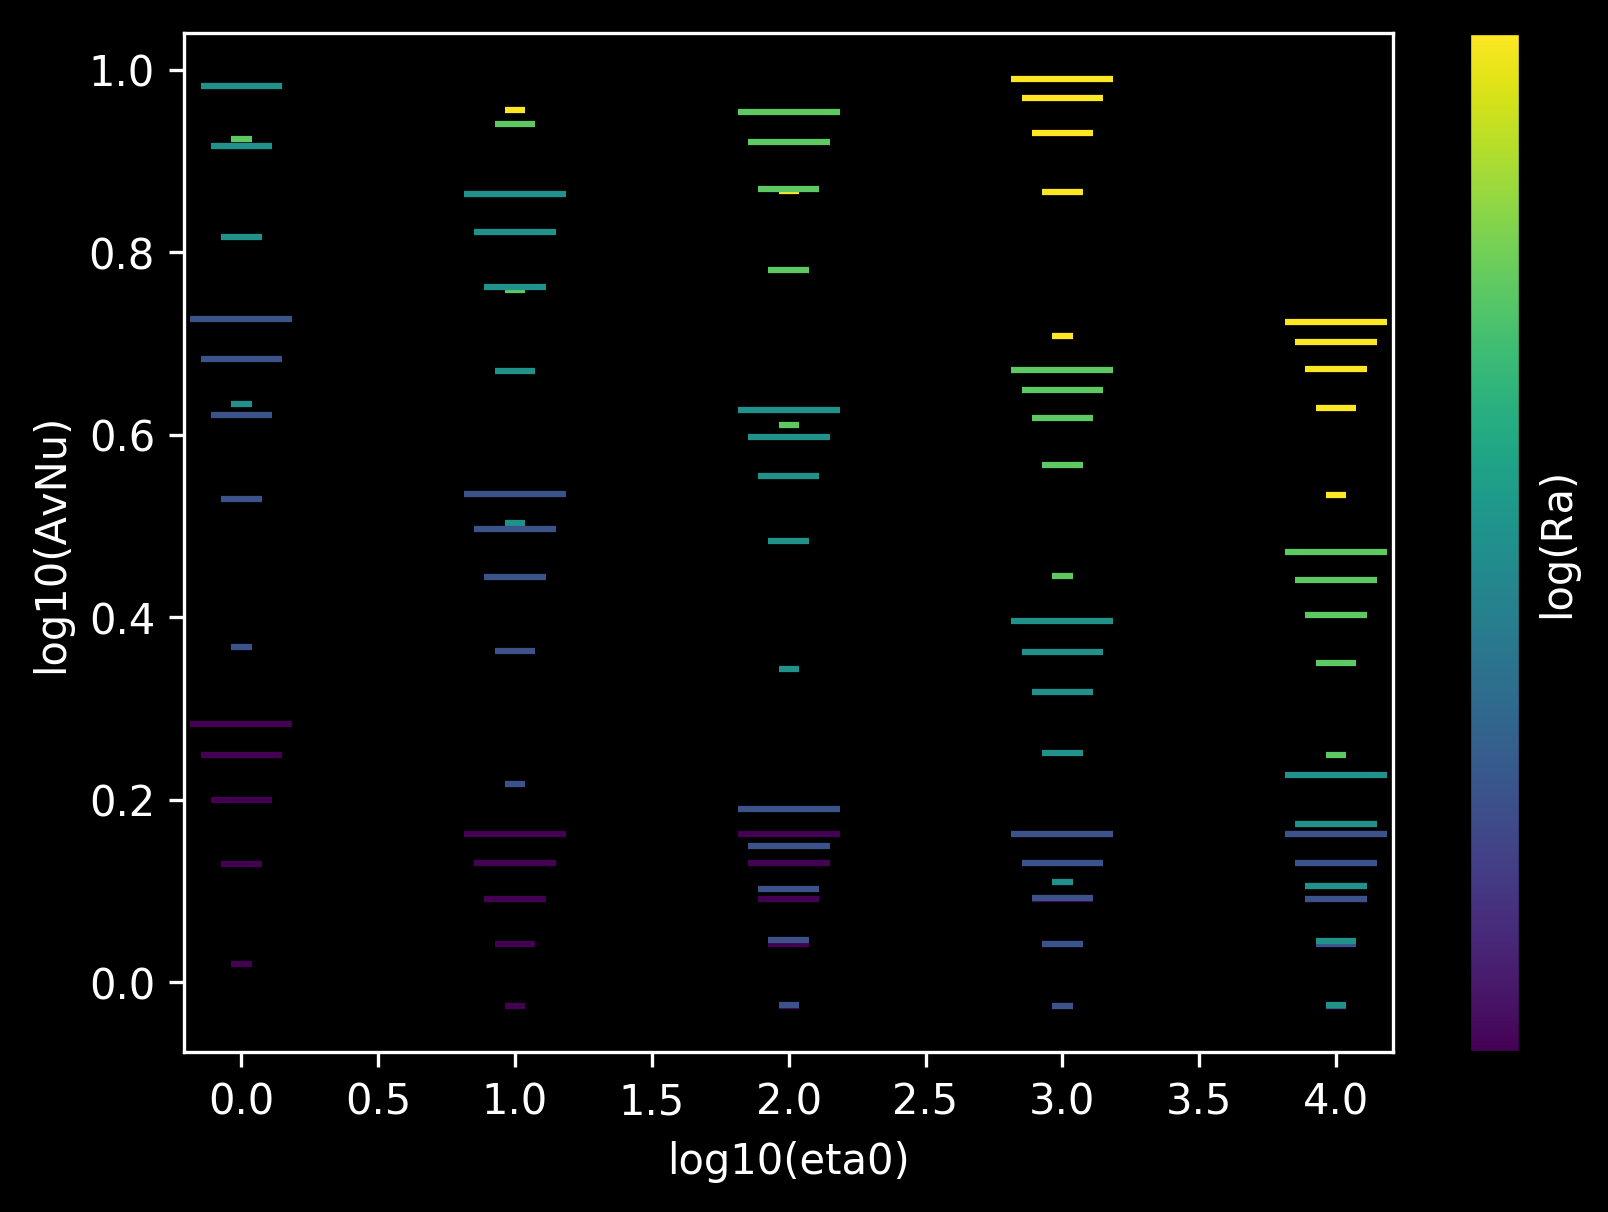

In [14]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

widthInches = 10
heightInches = 10

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

logRas = np.log10(Ras)

cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(
    vmin = np.min(logRas),
    vmax = np.max(logRas)
    )

scatter = ax.scatter(
    np.log10(eta0s),
    np.log10(NuAvs),
    c = norm(logRas),
    cmap = cmap,
    s = 600. * fs ** 2,
    edgecolor = 'white',
    alpha = 1.,
    marker = '_'
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

# for val in sorted(set(subFrame['logRaf2'])):
#     subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
#     xs = subsubFrame['log10Eta0s']
#     ys = subsubFrame['log10NuAvs']
#     zs = np.polyfit(xs, ys, 1)
#     p = np.poly1d(zs)
#     if regressionDict[round(val, 2)][2] > 0.9:
#         plt.plot(xs, p(xs), "w", alpha = 0.5)

In [15]:
eta0_regression_header, eta0_regression = regress_series(allDataFrame, 'logEta0s', 'logNuAvs', key = 'logRaf2')
eta0_regression_dict = dict(eta0_regression)
eta0_regression_filtered = [row for row in eta0_regression if row[1][2] > 0.9]
eta0_regression_filtered_dict = dict(eta0_regression_filtered)

In [29]:
eta0_regression

[(3.69, [[-0.01], 0.0, 0.5]),
 (5.08, [[-0.02], 0.22, 0.5]),
 (5.89, [[-0.02], 0.36, 0.5]),
 (5.99, [[-0.1], 0.71, 0.8]),
 (6.46, [[-0.02], 0.46, 0.5]),
 (6.91, [[-0.02], 0.54, 0.5]),
 (7.38, [[-0.13], 1.07, 0.8]),
 (8.19, [[-0.14], 1.27, 0.81]),
 (8.29, [[-0.17], 1.51, 0.99]),
 (8.76, [[-0.15], 1.41, 0.82]),
 (9.21, [[-0.15], 1.51, 0.83]),
 (9.68, [[-0.2], 1.95, 0.99]),
 (10.49, [[-0.21], 2.18, 1.0]),
 (10.6, [[-0.17], 2.14, 1.0]),
 (11.07, [[-0.21], 2.31, 1.0]),
 (11.51, [[-0.21], 2.45, 0.99]),
 (11.98, [[-0.2], 2.66, 1.0]),
 (12.79, [[-0.23], 3.06, 1.0]),
 (12.9, [[-0.14], 2.59, 0.98]),
 (13.37, [[-0.24], 3.2, 0.99]),
 (13.82, [[-0.24], 3.27, 0.99]),
 (14.29, [[-0.24], 3.63, 1.0]),
 (15.1, [[-0.26], 3.93, 1.0]),
 (15.67, [[-0.27], 4.08, 1.0]),
 (16.12, [[-0.27], 4.12, 1.0])]

In [16]:
eta0_regression_filtered_dict

{8.29: [[-0.17], 1.51, 0.99],
 9.68: [[-0.2], 1.95, 0.99],
 10.49: [[-0.21], 2.18, 1.0],
 10.6: [[-0.17], 2.14, 1.0],
 11.07: [[-0.21], 2.31, 1.0],
 11.51: [[-0.21], 2.45, 0.99],
 11.98: [[-0.2], 2.66, 1.0],
 12.79: [[-0.23], 3.06, 1.0],
 12.9: [[-0.14], 2.59, 0.98],
 13.37: [[-0.24], 3.2, 0.99],
 13.82: [[-0.24], 3.27, 0.99],
 14.29: [[-0.24], 3.63, 1.0],
 15.1: [[-0.26], 3.93, 1.0],
 15.67: [[-0.27], 4.08, 1.0],
 16.12: [[-0.27], 4.12, 1.0]}

In [17]:
averageGoodSlope = np.average([row[1][0][0] for row in eta0_regression_filtered])
averageGoodSlopeScore = np.average([row[1][2] for row in eta0_regression_filtered])
(averageGoodSlope, averageGoodSlopeScore)

(-0.21733333333333332, 0.9953333333333334)

Text(0.5, 1.0, '(average slope, score > 0.9 = -0.22)')

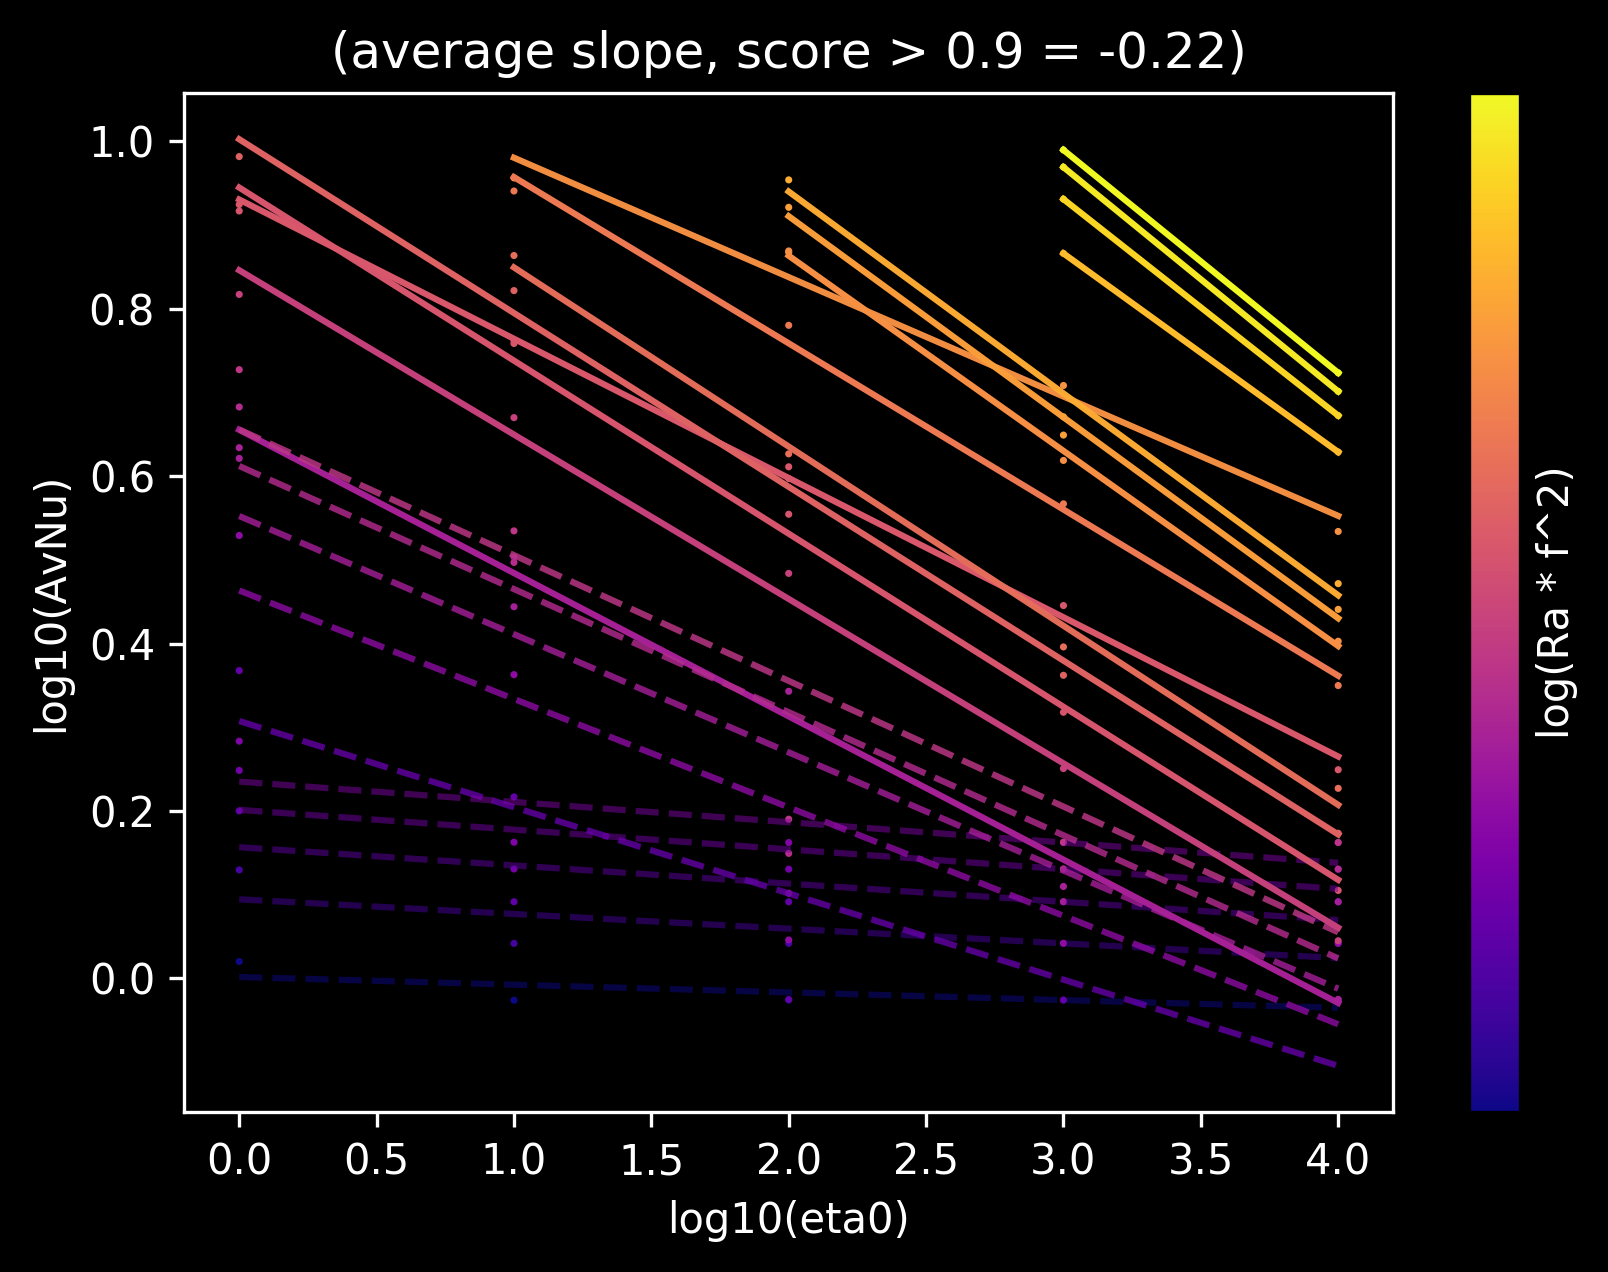

In [18]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

widthInches = 10
heightInches = 10

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']

cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    subFrame['log10Eta0s'],
    subFrame['log10NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 0.5,
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter, alpha = 1.)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

for val in sorted(set(subFrame['logRaf2'])):
    subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
    xs = subsubFrame['log10Eta0s']
    ys = subsubFrame['log10NuAvs']
    zs = np.polyfit(xs, ys, 1)
    p = np.poly1d(zs)
    score =  eta0_regression_dict[round(val, 2)][2]
    if score > 0.9:
        linestyle = '-'
    else:
        linestyle = '--'
    alpha = score
    plt.plot(
        xs,
        p(xs),
        color = cmap(norm(val)),
        alpha = alpha,
        linestyle = linestyle
        )

plt.title("(average slope, score > 0.9 = %.2f)"%averageGoodSlope)

In [47]:
eta0_regression_filtered

[(8.29, [[-0.17], 1.51, 0.99]),
 (9.68, [[-0.2], 1.95, 0.99]),
 (10.49, [[-0.21], 2.18, 1.0]),
 (10.6, [[-0.17], 2.14, 1.0]),
 (11.07, [[-0.21], 2.31, 1.0]),
 (11.51, [[-0.21], 2.45, 0.99]),
 (11.98, [[-0.2], 2.66, 1.0]),
 (12.79, [[-0.23], 3.06, 1.0]),
 (12.9, [[-0.14], 2.59, 0.98]),
 (13.37, [[-0.24], 3.2, 0.99]),
 (13.82, [[-0.24], 3.27, 0.99]),
 (14.29, [[-0.24], 3.63, 1.0]),
 (15.1, [[-0.26], 3.93, 1.0]),
 (15.67, [[-0.27], 4.08, 1.0]),
 (16.12, [[-0.27], 4.12, 1.0])]

In [50]:
logRaf2s = [row[0] for row in eta0_regression_filtered]
intercepts = [row[1][1] for row in eta0_regression_filtered]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(logRaf2s, intercepts)
print("Slope: ", round(slope, 2), ", score: ", round(rvalue, 2), ", intercept: ", round(intercept, 2))

Slope:  0.35 , score:  0.99 , intercept:  -1.56


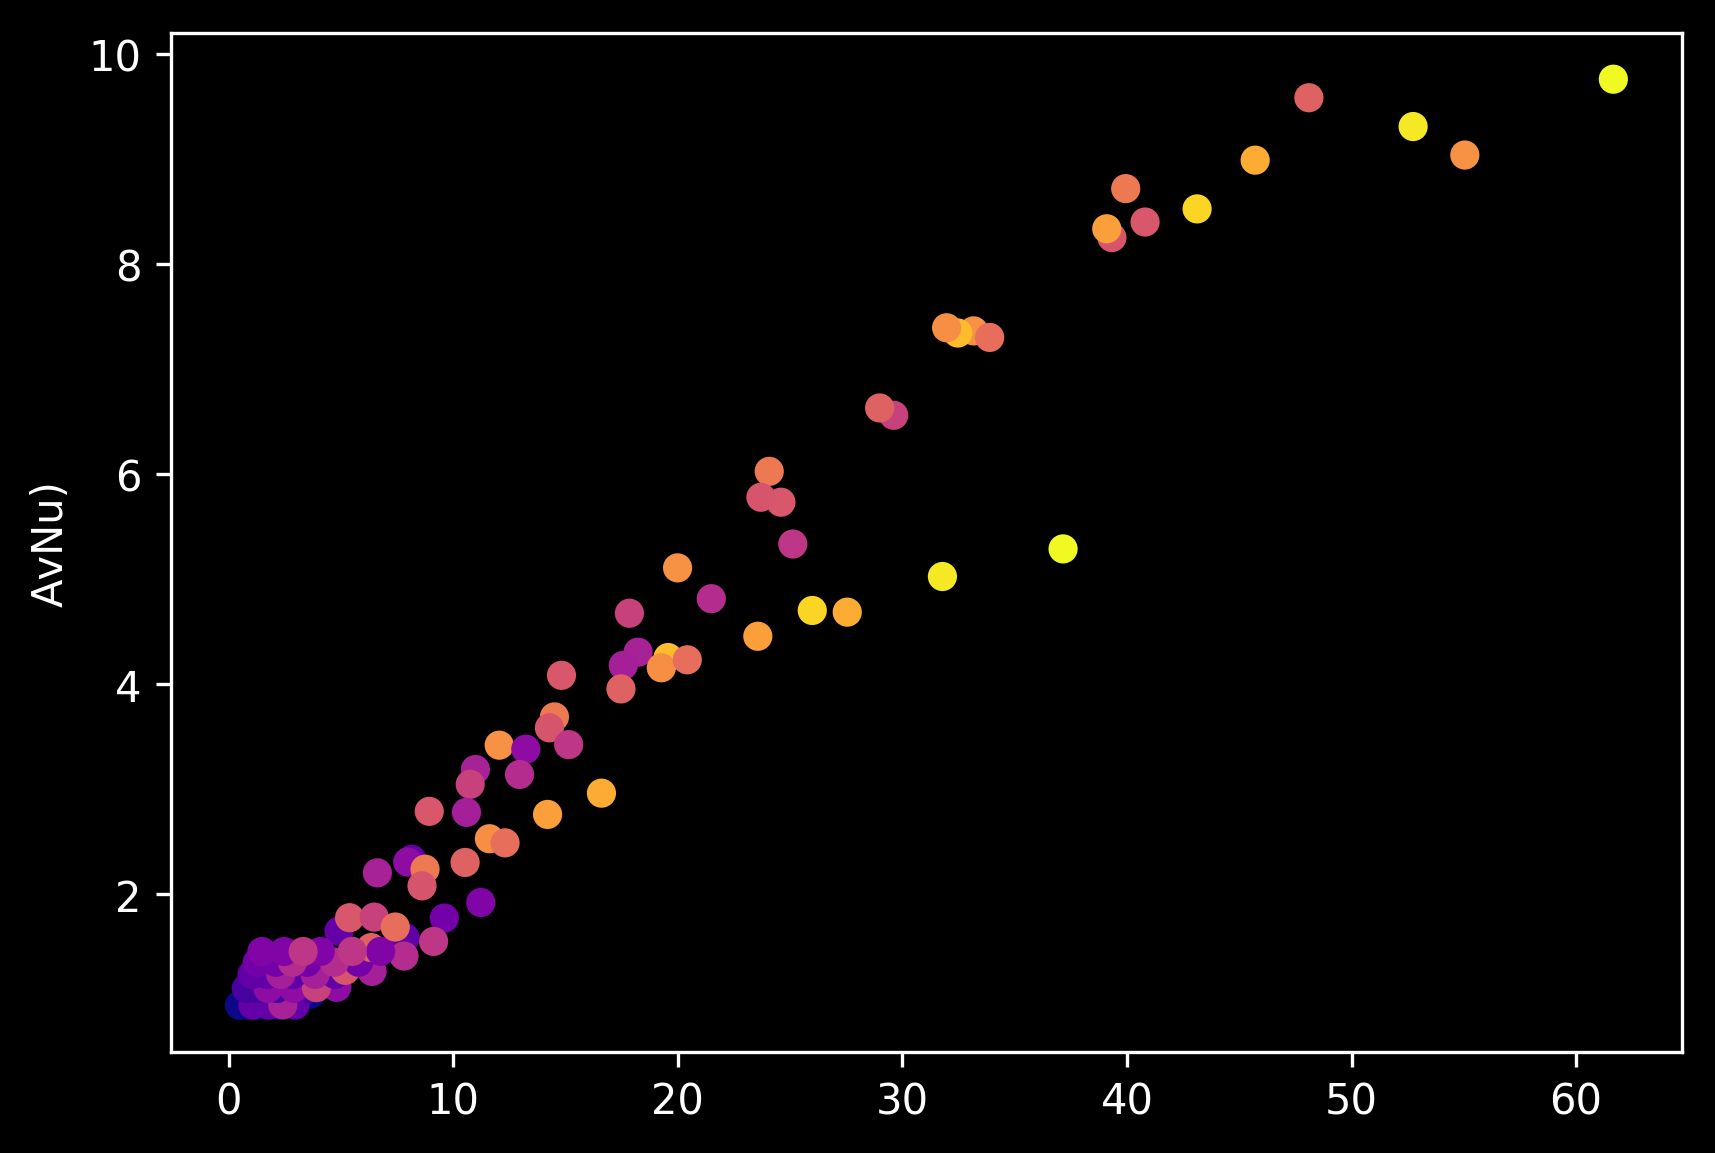

In [51]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# ax.set_xlabel('log(eta0)')
ax.set_ylabel('AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    subFrame['Raf2'] ** 0.35 / subFrame['eta0s'] ** 0.22,
    subFrame['NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
#     s = 0.5,
#     edgecolor = 'white',
#     alpha = 0.1,
    )

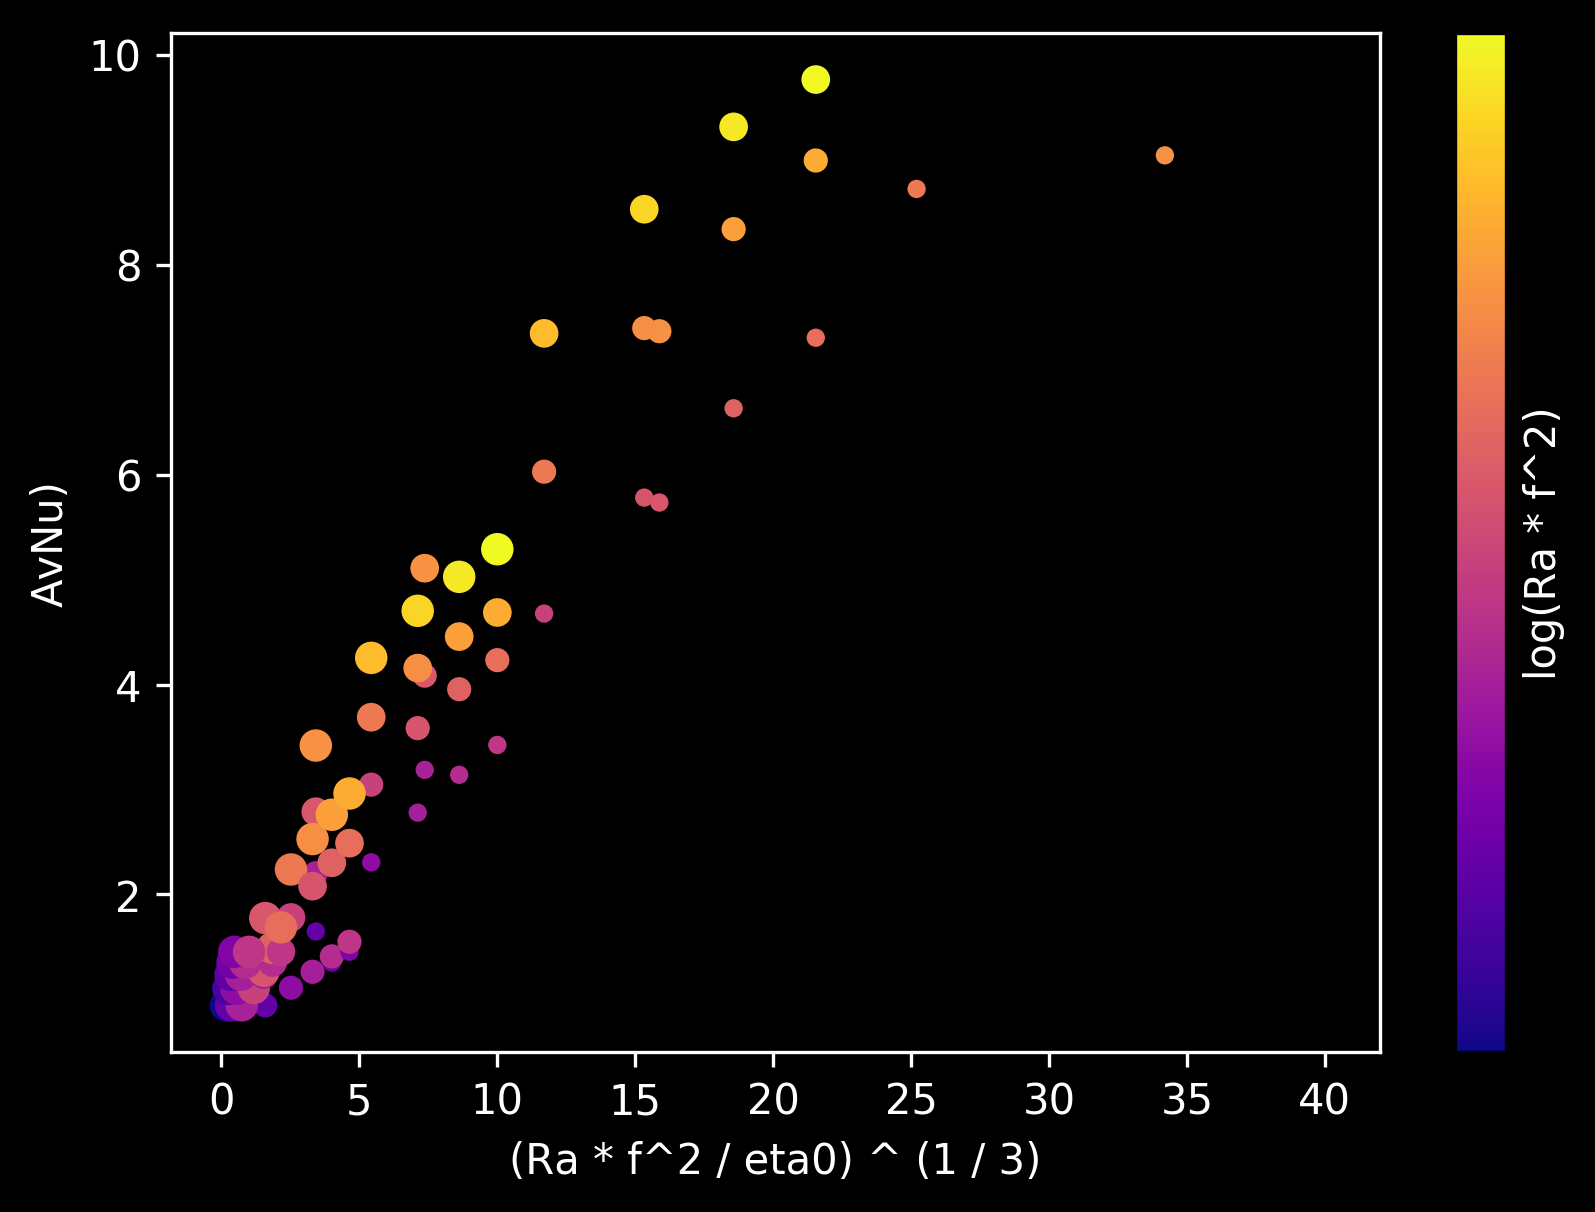

In [81]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (6.5, 4.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('(Ra * f^2 / eta0) ^ (1 / 3)')
ax.set_ylabel('AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    (subFrame['Raf2'] / subFrame['eta0s']) ** (1. / 3.),
    subFrame['NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 5. * subFrame['logEta0s'],
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

In [79]:
allDataFrame['THEORETICALSCALING'] = (allDataFrame['Raf2'] / allDataFrame['eta0s']) ** (0.31)

In [80]:
regress(allDataFrame, 'THEORETICALSCALING', 'NuAvs')

("NuAvs vs ['THEORETICALSCALING']; coef, intercept, score:",
 [[0.35], 1.05, 0.82])

In [42]:
allDataFrame['Raf2/eta0'] = allDataFrame['Raf2'] / allDataFrame['eta0s']
allDataFrame['log(Raf2/eta0)'] = np.log(allDataFrame['Raf2/eta0'])
allDataFrame['Raf2/sqrteta0'] = allDataFrame['Raf2'] / np.sqrt(allDataFrame['eta0s'])
allDataFrame['log(Raf2/sqrteta0)'] = np.log(allDataFrame['Raf2/sqrteta0'])

In [40]:
regress_series(allDataFrame, 'log(Raf2/eta0)', 'logNuAvs', 'eta0s')

("eta0s; logNuAvs vs ['log(Raf2/eta0)']; coef, intercept, score:",
 [(1.0, [[0.32], -1.3, 0.97]),
  (10.0, [[0.29], -0.67, 0.97]),
  (100.0, [[0.26], -0.26, 0.91]),
  (1000.0, [[0.21], 0.2, 0.92]),
  (10000.0, [[0.15], 0.45, 0.83])])

In [41]:
regress(allDataFrame, 'log(Raf2/eta0)', 'logNuAvs')

("logNuAvs vs ['log(Raf2/eta0)']; coef, intercept, score:",
 [[0.17], 0.21, 0.77])

In [43]:
regress(allDataFrame, 'log(Raf2/sqrteta0)', 'logNuAvs')

("logNuAvs vs ['log(Raf2/sqrteta0)']; coef, intercept, score:",
 [[0.22], -0.57, 0.86])